# Getting Heads 2

This notebook aims to develop a new method of head detection using insights gained from the first version of this data. This new effort improves on the previous one in two main ways:

* head selection is performed using Text Fabric templates, which offers a clearer, more transparent way to select and filter data
* aims to track and address all edge cases

Most of the rationale and rules generated in [getting_heads.ipynb](getting_heads.ipynb) are carried over to this present notebook.

In [1]:
from tf.app import use
from IPython.display import display
import collections, random, csv, re, textwrap
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
A = use('bhsa', hoist=globals())

Using etcbc/bhsa/tf - c r1.4 in /Users/cody/text-fabric-data
Using etcbc/phono/tf - c r1.1 in /Users/cody/text-fabric-data
Using etcbc/parallels/tf - c r1.1 in /Users/cody/text-fabric-data


**Documentation:** <a target="_blank" href="https://etcbc.github.io/bhsa" title="provenance of BHSA = Biblia Hebraica Stuttgartensia Amstelodamensis">BHSA</a> <a target="_blank" href="https://dans-labs.github.io/text-fabric/Writing/Hebrew" title="('Hebrew characters and transcriptions',)">Character table</a> <a target="_blank" href="https://etcbc.github.io/bhsa/features/hebrew/c/0_home.html" title="BHSA feature documentation">Feature docs</a> <a target="_blank" href="https://dans-labs.github.io/text-fabric/Apps/Bhsa/" title="bhsa API documentation">bhsa API</a> <a target="_blank" href="https://dans-labs.github.io/text-fabric/Api/General/" title="text-fabric-api">Text-Fabric API 7.2.1</a> <a target="_blank" href="https://dans-labs.github.io/text-fabric/Use/Search/" title="Search Templates Introduction and Reference">Search Reference</a>

In [3]:
# configure display
A.displaySetup(condenseType='phrase', withNodes=True, end=50, extraFeatures={'st'})

In [4]:
def show_subphrases(phrase, direction=L.d):
    '''
    A simple function to print subphrases
    and their relations to each other.
    '''
    for sp in direction(phrase, 'subphrase'):
        
        mother = E.mother.f(sp)[0] if E.mother.f(sp) else ''
        mother_text = T.text(mother)
        
        print('-'*7 + str(sp) + '-'*16)
        print()
        print(f'{T.text(sp)} -{F.rela.v(sp)}-> {mother_text}')
        print(f'nodes:  {sp} -{F.rela.v(sp)}-> {mother}')
        print(f'slots:  {L.d(sp, "word")} -{F.rela.v(sp)}-> {L.d(mother or 0, "word")}')
        print('-'*30)

# Defining Heads

The basic definition of a phrase head from the previous version is carried over here, which is:
> the word with a part of speech after which a phrase type is named

As applied in the previous effort, this includes a secondary criterion:
> the word which semantically determines grammatical agreement

This latter case thus excludes quantifiers such as כל and cardinal numbers that are in construct or attribution to a given word.

From the point of view of the ETCBC database, heads can be extracted using the `subphrase` object and its relations. These relations are not always coded in a transparent or beneficial way. But they are at least useful enough to disambiguate independent words from dependent words. From the ETCBC database perspective, we add a third criterion:
> a word contained in an independent subphrase or a subphrase only dependent upon a quantifier

# Preprocessing Data

Before beginning the head selections, a number of important preprocessing tasks must be performed. This includes building up necessary custom sets that can be used to correctly select the heads, as well as accounting for shortcomings in the BHSA data. In this section the preprocessing is done.

## Prepare Custom Sets

Below I prepare a series of custom sets that can in turn be used in the head search templates. `A.search` takes an optional argument `sets` which is a dictionary of string keys and set values. The string keys can be written into search templates, so that a key of "wordKind", for instance, can be entered into the template as if it is an object. All of the instantiations of "wordKind" are identified by looking at the set, which contains object nodes (e.g. word nodes). 

In [5]:
sets = {}

### `iphrase_atom` (independent phrase atom)

Below is a set of independent phrase atoms. This set is needed since phrase atoms can exist within a chain of other coordinate phrase atoms, which itself may begin with a dependent element. By definition, a head is not a dependent element. So only phrase atoms in independent chains should be allowed. This requires a recursive check down the phrase atom chain to ensure all relations are independent.

In [6]:
def climb_pa_chain(relalist, phrase_atom):
    '''
    Recursive function that climbs 
    down phrase_atom parallel chains
    to identify all relations in the chain.
    '''
    mother = E.mother.f(phrase_atom)[0]
    relalist.append(F.rela.v(mother))
    if F.rela.v(mother) == 'Para':
        climb_pa_chain(relalist, mother)
        
# iterate through phrase atoms, apply climb_pa_chain, use resulting relations to select iphrase_atoms:
independent_phrasea = [pa for pa in F.otype.s('phrase_atom') if F.rela.v(pa) == 'NA']
for pa in F.rela.s('Para'):  
    chained_relas = []
    climb_pa_chain(chained_relas, pa)
    if not set(chained_relas) - {'NA', 'Para'}: # <- dependency check happens here: only allowable relas are NA and Para
        independent_phrasea.append(pa)
        
iphrase_atom = set(independent_phrasea)

sets['iphrase_atom'] = iphrase_atom

print(f'{len(iphrase_atom)} independent phrase atoms ready...')

254624 independent phrase atoms ready...


### `quant` (quantifiers)

Different lexemes are used to quantify nouns in the Hebrew Bible. Cardinal numbers are indicated in the BHSA with the feature `ls` (lexical set) and a value of `card`. However, other, more qualitative quantifiers are not formally marked, including lemmas such as כל or חצי. Also not included is the use of בן + cardinal number, where בן functions idiomatically as a part of the quantifying phrase rather than a true head. These cases are defined below and gathered into a `quant` set. 

In [7]:
custom_quants = {'KL/', 'M<V/', 'JTR/',
                 'M<FR/', 'XYJ/', '<FRWN/',
                 'C>R=/', 'MSPR/'}

quantlexs = '|'.join(custom_quants) # pipe separated string for optional use in search templates

# for the Hebrew idiom: בנ + quantifier for age
son_quantifiers = set(res[0] for res in A.search('''

phrase_atom
    word lex=BN/ st=c nu=sg
    <: word ls=card

''', silent=True))

construct_quants = set(res[0] for res in A.search('''

phrase_atom
    word lex=C>R=/|MSPR/ st=c
    <: word pdp=subs|nmpr

''')
)
# for use as quantifier set
quantifiers = set(w for w in F.otype.s('word')
                  if F.lex.v(w) in custom_quants
                  or F.ls.v(w) == 'card')

quantifiers |= (son_quantifiers)

sets['quant'] = quantifiers

print(f'{len(quantifiers)} custom quantifiers ready...')

  0.94s 75 results
12453 custom quantifiers ready...


### `prep` (prepositions)

Many prepositions are marked in BHSA with the feature `pdp` (phrase dependent part of speech) with a value of `prep`. However, this is not true of all prepositions. Other prepositions are marked with the `ls` (lexical set) feature with a value of `ppre` (potential preposition). Still other semi-prepositional lemmas are missed, such as פנה when used before ל (as in לפני), words indicating position, such as תוך (middle), קץ (end), or those indicating continuity such as עוד (still).

Preposition definitions need to be further investigated and defended. Some terms that are pseudo-prepositional, such as פתח "entrance" (e.g. in פתח אהל "entrance of a tent"), are not included. More investigation is needed to determine sound criteria for prepositions as a discrete class.

In [8]:
# prepare prepositions set

preps = [w for w in F.otype.s('word') if F.pdp.v(w) == 'prep']

# add special בד "alone" when it is 
# preceded by ל, with a meaning of "except"
preps.extend(A.search('''

prep:word lex=BD/
/with/
phrase_atom
    word pdp=prep lex=L
    <: prep
/-/

''', shallow=True, silent=True))

# The prepositions below are lemma sets like פנה or תוך
# These sets could benefit from further investigation
preps.extend(A.search('''

prep:word st=c lex=PNH/|TWK/|QY/|QYH=/|<WD/
/with/
phrase_atom
    word pdp=prep
    <: prep
/-/

''', shallow=True, silent=True))

# The prepositions below are a bit more experimental and are restricted 
# to construct positions before cardinal numbers
# for ראש, there are other relevant examples—but these have to be disambiguated
# possibly if we have animacy measurement, we can generate ראש preps based on whether
# the word it is construct to is animate or not
preps.extend(A.search('''

prep:word st=c lex=R>C/
/with/
phrase_atom
    word pdp=prep
    <: prep
/-/
/with/
prep
<: word ls=card
/-/
''', shallow=True, silent=True))

# Below potential preps are added, but דרך is excluded
# since this is a more speculative preposition
preps.extend(A.search('''

word ls=ppre st=c lex#DRK/

''', shallow=True, silent=True))

preps = set(preps)

sets['prep'] = preps

print(f'{len(preps)} custom prepositions ready...')

76878 custom prepositions ready...


### `nonprep`, `quantprep`, and `nonquantprep`

The custom prepositions defined below are often marked in BHSA with a `pdp` (phrase dependent part of speech) of `subs` (substantive) rather than `prep`. This results in unwanted selections. Furthermore, there are many cases where the selection of a quantifier is to be explicitly disallowed. The sets `nonprep`, `quantprep`, and `nonquantprep` enable exclusions or selections to be made without lengthening the search templates. 

In [9]:
quantpreps = quantifiers|preps

# non quantifiers
non_quant = set(w for w in F.otype.s('word') if w not in quantifiers)

# non prepositions
non_prep = set(w for w in F.otype.s('word') if w not in preps)

# non quantifiers or prepositions
nonquantprep = set(w for w in F.otype.s('word') if w not in quantpreps)

sets['nonprep'] = non_prep
sets['nonquant'] = non_quant
sets['nonquantprep'] = nonquantprep

print(f'{len(non_quant)} non-quantifying words ready')
print(f'{len(non_prep)} non-prepositional words ready')
print(f'{len(nonquantprep)} non-prepositional, non-quantifier words ready')

414256 non-quantifying words ready
349706 non-prepositional words ready
337378 non-prepositional, non-quantifier words ready


### `postprep` and `nonpostprep`

It is often necessary to ensure a word is or isn't preceded immediately by a preposition. Due to the potential presence of an intermediating article, these cases can become lengthy within the templates. These two sets provide a way to reference these words simply.

In [10]:
precede_prep = A.search('''

word
/with/
phrase_atom
    prep
    <: ..
/or/
phrase_atom
    prep
    <: word pdp=art
    <: ..
/-/
''', shallow=True, sets=sets, silent=True)

postprep = set(precede_prep)
nonpostprep = set(w for w in F.otype.s('word') if w not in postprep)

sets['postprep'] = postprep
sets['nonpostprep'] = nonpostprep

print(f'{len(postprep)} post prepositional words ready...')
print(f'{len(nonpostprep)} non-post prepositional words ready...')

76123 post prepositional words ready...
350461 non-post prepositional words ready...


## Missing Relation Problems in BHSA

The BHSA subphrases have several missing relations that prevent correct head selection. These missing relations illustrate the urgent need for a new data model that can address the shortcomings. Some of these issues may be due to limitations in the ETCBC data creation pipeline. For instance, in that pipeline, a word can only exist in a maximum of 3 subphrase relations. This limitation is caused by the outdated file format of [ps3.p](http://www.etcbc.nl/datacreation/#ps3.p). A BHSA2 that is native to Text-Fabric could address this shortcoming easily.

As a temporary solution, a set is created (`dword`, dependent word), which contains all words that *should* be in a dependent subphrase relation but are not. This set is in turn used to make a set of `iword` (independent_word). For the heads selections, all templates will search for `iword` objects rather than simple `word`. 

In [11]:
dwords = set()

### Missing `atr` and `rec`

There are at least 96 cases in BHSA, found below, which lack a proper `atr` (attribution) or `rec` (nomen regens/rectum) subphrase relation. Manual inspection of the subprhase structures show that this is frequently the case due to the word existing in more than 3 subphrases (the max for ps3.p). Selecting these cases consists of the following parameters:

* find all cases of `subs + subs` or `subs + adjv` in adjacent relation; intervention of a definite article is allowed
* ensure that there is no subphrase that relates the second nominal element to the first
* ensure that the first nominal is in the construct relation
* OR ensure that (1) second nominal is an adjective, or (2) first nominal ends with maqqeph (e.g. כל־), or (3) nominal 1 and 2 occur together and alone in a subphrase.

Coding all of these requirements results in a bit of a lengthy search pattern, but it is effective in isolating the relevant cases. The cases are searched for and displayed below. The head noun is highlighted in green, while the word in relation to it is in pink. Again, the pink words are words which SHOULD have a relation to the green word, but do not have one in BHSA.

In [12]:
missing_atr_rec = A.search('''

phrase
    phrase_atom
        subs:nonquantprep pdp=subs|nmpr    
% stipulate that this word has some relation to the following word
% there are various checks to weed out spurious results:
        /with/
        st=c
        /or/
        ..
        <: word pdp=adjv
        /or/
        trailer=&
        /or/
        s1:subphrase
            =: subs
            <: w1:word pdp=adjv|subs
        w1 := s1
        /-/
        
        <: ad:word pdp=adjv|subs
% stipulate that this^ word has no relation to the first
        /without/
        s1:subphrase
            w1:word
        s2:subphrase rela=atr|adj|par|mod
            w2:word
        s1 <mother- s2
        w1 <: w2
        ad = w2
        /-/
        /without/
        w1:word
        s1:subphrase rela=rec
            w2:word
        w1 <mother- s1
        w1 <: w2
        ad = w2
        /-/

''', sets={'nonquantprep':nonquantprep}) + A.search('''

phrase
    phrase_atom
        nonquantprep pdp=subs|nmpr
        <: word pdp=art
        <: ad:word pdp=adjv|subs
% stipulate that this^ word has no relation to the first
        /without/
        s1:subphrase
            w1:word pdp=subs|nmpr
        s2:subphrase rela=atr|adj|par|mod
            w2:word pdp=art
            <: w3:word
            
        s1 <mother- s2
        w1 <: w2
        ad = w3
        /-/
        
        /without/
        w1:word pdp=subs|nmpr
        s1:subphrase rela=rec
            w2:word pdp=art
            w3:word
            
        w1 <mother- s1
        w1 <: w2
        ad = w3
        /-/
''', sets={'nonquantprep':nonquantprep})

  1.41s 45 results
  2.25s 33 results


In [13]:
random.shuffle(missing_atr_rec)

In [14]:
cutoff = 25

for i, res in enumerate(missing_atr_rec[:cutoff]):
    subs = res[2]
    atr = res[3] if len(res) == 4 else res[4]
    highlights = {subs:'lightgreen', atr:'pink'}
    A.prettyTuple(res, end=100, seqNumber=i+1, highlights=highlights)

print(f'\t\t\t\t...RESULTS CUT OFF AT {cutoff}...')



**Result** *1*





**Result** *2*





**Result** *3*





**Result** *4*





**Result** *5*





**Result** *6*





**Result** *7*





**Result** *8*





**Result** *9*





**Result** *10*





**Result** *11*





**Result** *12*





**Result** *13*





**Result** *14*





**Result** *15*





**Result** *16*





**Result** *17*





**Result** *18*





**Result** *19*





**Result** *20*





**Result** *21*





**Result** *22*





**Result** *23*





**Result** *24*





**Result** *25*



				...RESULTS CUT OFF AT 25...


For all of these cases, we add the second substantive (pink) into the `dwords` set:

In [15]:
dwordsadded = 0
for res in missing_atr_rec:
    dword = res[3] if len(res) == 4 else res[4]
    dwords.add(dword)
    dwordsadded += 1
print(f'{dwordsadded} words added to dwords...')

78 words added to dwords...


#### Jer 9:23, missed משפת
There is one case where משפת occurs together with חסד in Jer 9:23. Because it occurs in no other subphrase, and is contained only with חסד, this word has incorrectly been marked above as a `dword`. This happens because this word's subphrase pattern is unique in the BHSA dataset. We thus make an exclusion here and remove it. However, to do so requires careful selection of the word node to avoid problems when the data changes. Thus, we apply a somewhat lengthy search template that isolates this and only this word to remove from `dword`. 

In [16]:
fix_mishpat = A.search('''

book book@en=Jeremiah
    chapter chapter=9
        verse verse=23
            word lex=MCPV/
''')

missed_mishpat = fix_mishpat[0][-1]

A.prettyTuple((missed_mishpat,), seqNumber=0)

  0.44s 1 result




**Result** *0*



In [17]:
missed_mishpat in dwords

True

In [18]:
# remove it from dword

dwords.remove(missed_mishpat)
missed_mishpat in dwords

False

#### Missing בתר in Gen 15:10

Another accidental addition `dwords` is this case in Gen 15:10 where the substantive בתר is modified by אישׁ. This case is unique because the two are separated with a maqqeph, but the first item modifies the second (rather than the other way around). We remove בתר from `dwords`. 

In [19]:
fix_btr = A.search('''

book book@en=Genesis
    chapter chapter=15
        verse verse=10
            word lex=BTR/

''')

missed_btr = fix_btr[0][-1]

A.prettyTuple((missed_btr,), seqNumber=0)

  0.45s 1 result




**Result** *0*



In [20]:
dwords.remove(missed_btr)
missed_btr in dwords

False

#### Coordinations with Modifying Term

There remain multiple cases where the modifying words selected above have a coordinate word. We isolate those cases below and add them to `dwords`. 

In [21]:
par_dwords = A.search('''

phrase
    s1:subphrase
    /without/
        quant
    /-/
        =: dword
    s2:subphrase rela=par
        word pdp=subs|nmpr|adjv
        /without/
        subphrase rela=NA
            ..
        /-/
s1 <mother- s2

''', sets={'dword':dwords, 'quant': quantifiers}) + A.search('''

phrase
    s1:subphrase
    /without/
        quant
    /-/
        := dword
    s2:subphrase rela=par
        word pdp=subs|nmpr|adjv
        /without/
        subphrase rela=NA
            ..
        /-/
s1 <mother- s2

''', sets={'dword':dwords, 'quant': quantifiers})


new_par_dwords = set()

for res in par_dwords:    
    newdword = res[4]
    new_par_dwords.add(newdword)
    dwords.add(newdword)
    
print(f'{len(new_par_dwords)} new dwords added to dword set...')

  1.10s 5 results
  0.90s 12 results
12 new dwords added to dword set...


### Missing Quantifier Relations

During the testing and development of these templates, a number of subphrase mistakes were found in the data. These primarily consist of missing relations between quantified elements and the cardinal number, as seen below. The code displays the phrases in question, their selected heads, and the subphrase relations found within them. The lack of a subphrase containing the number, or the lack of a relation from the number to the quantified has resulted in poorly-selected heads. Typically these relations are expressed with subphrase relations of `rec` or `adj`.

In [22]:
phrases_to_patch = []

# book, chapter, verse, clause_atom number, phrase number
missing_quant_relas = [('Daniel', 3, 23, 444, 2),
                       ('Daniel', 9, 25, 1423, 2),
                       ('Ezra', 1, 9, 39, 1),
                       ('Ezra', 1, 10, 42, 1),
                       ('Ezra', 8, 20, 621, 3),
                       ('1_Chronicles', 12, 29, 1071, 3)]

for book, chapter, verse, clat_nu, phrase_nu  in missing_quant_relas:
    findit = f'''    
    book book@en={book}
        chapter chapter={chapter}
            verse verse={verse}
                clause_atom number={clat_nu}
                    phrase number={phrase_nu}
    '''
    phrase = A.search(textwrap.dedent(findit))[0][4]
    
    A.prettyTuple((phrase,), seqNumber=0)
    print('subphrase relations:')
    show_subphrases(phrase)
        
    phrases_to_patch.append(phrase)

  0.49s 1 result




**Result** *0*



subphrase relations:
-------1395312----------------

גֻבְרַיָּ֤א  -NA-> 
nodes:  1395312 -NA-> 
slots:  [372116] -NA-> ()
------------------------------
-------1395313----------------

אִלֵּךְ֙  -dem-> גֻבְרַיָּ֤א 
nodes:  1395313 -dem-> 1395312
slots:  [372117] -dem-> [372116]
------------------------------
-------1395314----------------

שַׁדְרַ֥ךְ  -NA-> 
nodes:  1395314 -NA-> 
slots:  [372119] -NA-> ()
------------------------------
-------1395315----------------

מֵישַׁ֖ךְ  -par-> שַׁדְרַ֥ךְ 
nodes:  1395315 -par-> 1395314
slots:  [372120] -par-> [372119]
------------------------------
-------1395316----------------

מֵישַׁ֖ךְ  -NA-> 
nodes:  1395316 -NA-> 
slots:  [372120] -NA-> ()
------------------------------
-------1395317----------------

עֲבֵ֣ד נְגֹ֑ו  -par-> מֵישַׁ֖ךְ 
nodes:  1395317 -par-> 1395316
slots:  [372122] -par-> [372120]
------------------------------
  0.44s 1 result




**Result** *0*



subphrase relations:
-------1396382----------------

שָׁבֻעִ֞ים שִׁשִּׁ֣ים  -NA-> 
nodes:  1396382 -NA-> 
slots:  [376359, 376360] -NA-> ()
------------------------------
-------1396380----------------

שָׁבֻעִ֞ים  -NA-> 
nodes:  1396380 -NA-> 
slots:  [376359] -NA-> ()
------------------------------
-------1396381----------------

שִׁשִּׁ֣ים  -par-> שָׁבֻעִ֞ים 
nodes:  1396381 -par-> 1396380
slots:  [376360] -par-> [376359]
------------------------------
-------1396383----------------

שְׁנַ֗יִם  -par-> שָׁבֻעִ֞ים שִׁשִּׁ֣ים 
nodes:  1396383 -par-> 1396382
slots:  [376362] -par-> [376359, 376360]
------------------------------
  0.47s 1 result




**Result** *0*



subphrase relations:
-------1396930----------------

מַחֲלָפִ֖ים תִּשְׁעָ֥ה  -NA-> 
nodes:  1396930 -NA-> 
slots:  [378379, 378380] -NA-> ()
------------------------------
-------1396928----------------

מַחֲלָפִ֖ים  -NA-> 
nodes:  1396928 -NA-> 
slots:  [378379] -NA-> ()
------------------------------
-------1396929----------------

תִּשְׁעָ֥ה  -par-> מַחֲלָפִ֖ים 
nodes:  1396929 -par-> 1396928
slots:  [378380] -par-> [378379]
------------------------------
-------1396931----------------

עֶשְׂרִֽים׃ ס  -par-> מַחֲלָפִ֖ים תִּשְׁעָ֥ה 
nodes:  1396931 -par-> 1396930
slots:  [378382] -par-> [378379, 378380]
------------------------------
  0.45s 1 result




**Result** *0*



subphrase relations:
-------1396946----------------

כֵּלִ֥ים  -NA-> 
nodes:  1396946 -NA-> 
slots:  [378393] -NA-> ()
------------------------------
-------1396947----------------

אֲחֵרִ֖ים  -atr-> כֵּלִ֥ים 
nodes:  1396947 -atr-> 1396946
slots:  [378394] -atr-> [378393]
------------------------------
  0.43s 1 result




**Result** *0*



subphrase relations:
-------1398630----------------

נְתִינִ֖ים  -NA-> 
nodes:  1398630 -NA-> 
slots:  [381870] -NA-> ()
------------------------------
-------1398631----------------

מָאתַ֣יִם  -par-> נְתִינִ֖ים 
nodes:  1398631 -par-> 1398630
slots:  [381871] -par-> [381870]
------------------------------
-------1398632----------------

מָאתַ֣יִם  -NA-> 
nodes:  1398632 -NA-> 
slots:  [381871] -NA-> ()
------------------------------
-------1398633----------------

עֶשְׂרִ֑ים  -par-> מָאתַ֣יִם 
nodes:  1398633 -par-> 1398632
slots:  [381873] -par-> [381871]
------------------------------
  0.42s 1 result




**Result** *0*



subphrase relations:
-------1405362----------------

שָׂרִ֖ים עֶשְׂרִ֥ים  -NA-> 
nodes:  1405362 -NA-> 
slots:  [398214, 398215] -NA-> ()
------------------------------
-------1405360----------------

שָׂרִ֖ים  -NA-> 
nodes:  1405360 -NA-> 
slots:  [398214] -NA-> ()
------------------------------
-------1405361----------------

עֶשְׂרִ֥ים  -par-> שָׂרִ֖ים 
nodes:  1405361 -par-> 1405360
slots:  [398215] -par-> [398214]
------------------------------
-------1405363----------------

שְׁנָֽיִם׃ ס  -par-> שָׂרִ֖ים עֶשְׂרִ֥ים 
nodes:  1405363 -par-> 1405362
slots:  [398217] -par-> [398214, 398215]
------------------------------


Perhaps it is significant that all of these examples come from the same cluster of books: Daniel, Ezra, and 1 Chronicles. This may indicate that the individual who encoded these texts did not understand the standard for relations of quantification in the ETCBC database. These are all cases that a `BHSA2` should address. For now, it is fair to correct them manually by removing all quantifiers selected as heads from these phrses.

The template below is tuned to pick out these examples: primarily they are cases where a phrase atom contains a quantified substantive, and this substantive has no dependent subphrase relations. Two additional checks are made with `/or/` to cover the peculiar cases of Ezra 1:20 (כלים אחרים אלף, i.e. adjv intervenes between quantifier) and Daniel 3:23 (גבריא אלך תלתהן, i.e. where a demonstrative intervenes).

In [23]:
non_rela_cardinals = A.search('''
phrase
    phrase_atom
        
        w1:word ls=card
        
        /without/
        subphrase rela=atr|adj|rec
            ..
        /-/
        /with/
        phrase_atom
            nonquantprep pdp=subs|nmpr
            <: word ls=card prs=absent
            < w1 prs=absent
        /or/
        phrase_atom
            nonquantprep pdp=subs|nmpr
            <: word pdp=prde
            <: w1
        /or/
        phrase_atom
            nonquantprep pdp=subs|nmpr
            <: word pdp=adjv
            < w1 prs=absent
        /-/
        
''', sets=sets)

  1.72s 31 results


In [24]:
A.show([res for res in non_rela_cardinals if res[0] in phrases_to_patch])



**phrase** *1*





**phrase** *2*





**phrase** *3*





**phrase** *4*





**phrase** *5*





**phrase** *6*



Below we check to see how many of our cases are covered by these criteria.

In [25]:
accounted = set(phrases_to_patch) & set(res[0] for res in non_rela_cardinals)
len(accounted)

6

This covers all the missed quantifiers above as well as a few extra that I have manually inspected to ensure none are good heads.

In [26]:
dwordsadded = 0
for res in non_rela_cardinals:
    dword = res[2]
    dwords.add(dword)
    dwordsadded += 1
print(f'{dwordsadded} words added to dwords...')

31 words added to dwords...


## Incorrect Relation Assignment

There are a handfull of cases where the ETCBC data has a relation that points at the wrong object. The few cases below are those which could not be fixed programmatically due to the complexity of the problem.

### Incorrect `par` Relations

In [27]:
bad_pars = []

bad_par1 = '''

book book@en=Jeremiah
    chapter chapter=32
        verse verse=32
            phrase
                word lex=BN/
                <: word lex=JHWDH/
'''
badpar1_note = 'בני־יהודה should be parallel to בני־ישראל rather than רעת בני־ישראל'
bad_pars.append({'template':bad_par1, 'phrasei':3, 'badi':4, 'note':badpar1_note})

bad_par2 = '''

book book@en=Jeremiah
    chapter chapter=40
        verse verse=1
            phrase
                word lex=JHWDH/
'''
badpar2_note = 'יהודה should be parallel to ירושלים rather than גלות־ירושלים'
bad_pars.append({'template':bad_par2, 'phrasei':3, 'badi':4, 'note':badpar2_note})

In [28]:
bad_par_dwords = set()

for i, bp in enumerate(bad_pars):
    bp_res = A.search(bp['template'], silent=False)
    phrase = bp_res[0][bp['phrasei']]
    bad = bp_res[0][bp['badi']]
    bad_par_dwords.add(bad)
    
    print()
    A.prettyTuple((phrase, bad), seqNumber=bp['note'])
    print(f'subphrases containing slot {bad}')
    show_subphrases(bad, direction=L.u)

  1.06s 1 result





**Result** *בני־יהודה should be parallel to בני־ישראל rather than רעת בני־ישראל*



subphrases containing slot 252225
-------1366882----------------

בְנֵ֣י  -NA-> 
nodes:  1366882 -NA-> 
slots:  [252225] -NA-> ()
------------------------------
-------1366884----------------

בְנֵ֣י יְהוּדָ֗ה  -par-> רָעַ֨ת בְּנֵֽי־יִשְׂרָאֵ֜ל 
nodes:  1366884 -par-> 1366881
slots:  [252225, 252226] -par-> [252221, 252222, 252223]
------------------------------
-------1366885----------------

רָעַ֨ת בְּנֵֽי־יִשְׂרָאֵ֜ל וּבְנֵ֣י יְהוּדָ֗ה  -rec-> כָּל־
nodes:  1366885 -rec-> 252220
slots:  [252221, 252222, 252223, 252224, 252225, 252226] -rec-> ()
------------------------------
  0.66s 1 result





**Result** *יהודה should be parallel to ירושלים rather than גלות־ירושלים*



subphrases containing slot 256813
-------1368189----------------

יהוּדָ֔ה  -par-> גָּל֤וּת יְרוּשָׁלִַ֨ם֙ 
nodes:  1368189 -par-> 1368188
slots:  [256813] -par-> [256810, 256811]
------------------------------
-------1368190----------------

גָּל֤וּת יְרוּשָׁלִַ֨ם֙ וִֽיהוּדָ֔ה  -rec-> כָּל־
nodes:  1368190 -rec-> 256809
slots:  [256810, 256811, 256812, 256813] -rec-> ()
------------------------------
-------1368191----------------

כָּל־גָּל֤וּת יְרוּשָׁלִַ֨ם֙ וִֽיהוּדָ֔ה  -rec-> תֹ֨וךְ 
nodes:  1368191 -rec-> 256808
slots:  [256809, 256810, 256811, 256812, 256813] -rec-> ()
------------------------------


As can be seen in the subphrase printouts, these parallel relations do not point to the best subphrase. These problems are fixed below by adding the paralleled terms to `dwords`.

In [29]:
dwords |= bad_par_dwords
list(bad_par_dwords)[0] in dwords # sanity check

True

## Completing `iword`

Below `dword` is finalized and used to create the `iword` set.

In [30]:
iwords = set(w for w in F.otype.s('word') if w not in dwords)
sets['iword'] = iwords
sets['dword'] = dwords

# Selecting Heads

Now that the preprocessing procedures are complete, they can be applied to the search templates to find the phrase heads. I will follow a process of deduction for assigning heads to phrases. So, we first select all phrases, and then track which heads are accounted for.

In [31]:
remaining_phrases = set(result[0] for result in A.search('phrase')) # get all phrases
covered_phrases = set() # put covered phrases here
remaining_types = list(feat[0] for feat in F.typ.freqList(nodeTypes='phrase')) # track and elminate phrase types

  0.26s 253207 results


**All phrase to head assignments will be made in the dictionary below:**

In [32]:
phrase2heads = collections.defaultdict(set)

In order to assist the process of elimination, the functions below programmatically record the heads in `phrase2heads` and remove them from the remaining set. `query_heads` iterates through a dictionary of queries and calls `record_head` on each result. `heads_status` provides a simple readout of what phrases remain to be analyzed.

In [33]:
def record_head(phrase, head, mapping=phrase2heads, remaining=remaining_phrases, covered=covered_phrases):
    '''
    Simple function to track phrases
    with heads that are accounted for
    and to modify the phrase2heads
    dict, which is a mapping from a phrase
    node to its head nodes.
    '''
    # try/except accounts for phrases with plural heads, 
    # one of which is already recorded
    try:
          remaining.remove(phrase)
    except: 
        pass
    
    if F.otype.v(phrase) == 'word':
        raise Exception(f'node {phrase} is a word not a phrase!')
    
    mapping[phrase].add(head) # record it
    covered.add(phrase)
    
def query_heads(querydict, phrasei=0, headi=1, sets={}):
    '''
    Runs queries on phrasetype/query dict.
    Reports results.
    Adds results.
    
    phrasei - the index of the phrase result in the search template.
    headi - the index of the head result in the search template.
    sets - custom sets for TF search
    '''
    for phrasetype, query in querydict.items():
        print(f'running query on {phrasetype}')
        results = A.search(query, silent=True, sets=sets)
        print(f'\t{len(results)} results found')
        for res in results:
            phrase, head = res[phrasei], res[headi]
            record_head(phrase, head)
            
def heads_status():
    # simply prints accounted vs unaccounted heads
    print(f'{len(covered_phrases)} phrases matched with a head...')
    print(f'{len(remaining_phrases)} phrases remaining...')

## Simple Heads

The selection of heads for certain phrase types is very straightforward. Those are defined in the templates below and are subsequently applied. These phrase types are selected based on the survey of their subphrase relations as found in the old notebook.

In [34]:
simp_heads = dict(

PPrP = '''
% personal pronoun

phrase typ=PPrP
    iphrase_atom
        iword pdp=prps

''',

DPrP = '''
% demonstrative pronoun

phrase typ=DPrP
    iphrase_atom
        iword pdp=prde

''',

InjP = '''
% interjectional

phrase typ=InjP
    iphrase_atom
        iword pdp=intj

''',

NegP = '''
% negative

phrase typ=NegP
    iphrase_atom
        iword pdp=nega

''',

InrP = '''
% interrogative

phrase typ=InrP
    iphrase_atom
        iword pdp=inrg

''',
    
IPrP = '''
% interrogative pronoun

phrase typ=IPrP
    iphrase_atom
        iword pdp=prin

''',

) # end of dictionary

### Make Queries, Record Heads, See What Remains

Here we run the queries and run `record_head` over each result. In all of the templates the head is the second item in the result tuple.

In [35]:
query_heads(simp_heads, headi=2, sets=sets)
        
print('\n', '<>'*20, '\n')
heads_status()

running query on PPrP
	4386 results found
running query on DPrP
	790 results found
running query on InjP
	1883 results found
running query on NegP
	6742 results found
running query on InrP
	1291 results found
running query on IPrP
	798 results found

 <><><><><><><><><><><><><><><><><><><><> 

15866 phrases matched with a head...
237341 phrases remaining...


### Find Remaining Phrases

What phrases with the above types remain unaccounted for?

In [36]:
unaccounted_simp = set(phrase for phrase in remaining_phrases
                          if F.typ.v(phrase) in simp_heads)
len(unaccounted_simp)

0

In [37]:
for typ in simp_heads:
    remaining_types.remove(typ)
print(remaining_types)

['VP', 'PP', 'CP', 'NP', 'PrNP', 'AdvP', 'AdjP']


## Mostly Simple Heads

The next set of heads require a bit more care since they can contain a bigger variety of relationships.

### VP
There is only one complication for the VP: that is that there is one VP that has more than one verb:

In [38]:
mult_verbs = A.search('''

phrase typ=VP
/with/
    word pdp=verb
    < word pdp=verb
/-/
''')
A.show(mult_verbs, condenseType='clause')

  1.29s 1 result




**phrase** *1*



The template below excludes this case without ignoring VP's that do not necessarily begin with a verb.

In [39]:
VP = '''

phrase typ=VP
    
    head:iword pdp=verb
    
    /without/
    phrase
        word pdp=verb
        < head
    /-/

'''

VP_search = A.search(VP, sets=sets)

for phrase, head in VP_search:
    record_head(phrase, head)
    
heads_status()

  1.62s 69024 results
84890 phrases matched with a head...
168317 phrases remaining...


#### VP Sanity Check

We double check that the indicated phrase above only has one head.

In [40]:
phrase2heads[893310]

{403602}

See what's left...

In [41]:
unaccounted_vp = set(phrase for phrase in remaining_phrases
                          if F.typ.v(phrase) == 'VP')
len(unaccounted_vp)

0

In [42]:
remaining_types.remove('VP')
print(remaining_types)

['PP', 'CP', 'NP', 'PrNP', 'AdvP', 'AdjP']


### CP

The conjunction phrase is relatively straightforward. But there are 1140 cases where the conjunction is technically headed by a preposition in the ETCBC data. These are phrases such as בטרם and בעבור (see the more detailed analysis in the prev. notebook). It is not clear at all why the ETCBC encodes these as conjunction phrases. This is almost certainly a confusion of the formal `typ` value and the functional `function` label (with a value of `Conj`). Nevertheless, here we make a choice to select the preposition as the true head.

In a BHSA2, these cases ought to be repaired.

In [43]:
cp_heads = dict(

conj = '''

phrase typ=CP
/without/
    word pdp=prep
/-/
    iphrase_atom
        head:iword pdp=conj
        /without/
        phrase_atom
            word pdp=conj
            <: head
        /-/

''',
    
prep_conj = '''

phrase typ=CP
    iphrase_atom
        =: word pdp=prep

'''

)



In [44]:
query_heads(cp_heads, headi=2, sets=sets)
        
print('\n', '<>'*20, '\n')
heads_status()

running query on conj
	51341 results found
running query on prep_conj
	1140 results found

 <><><><><><><><><><><><><><><><><><><><> 

137371 phrases matched with a head...
115836 phrases remaining...


#### CP Sanity Check

In [45]:
unaccounted_cp = set(phrase for phrase in remaining_phrases
                          if F.typ.v(phrase) == 'CP')
len(unaccounted_cp)

0

In [46]:
remaining_types.remove('CP')
print(remaining_types)

['PP', 'NP', 'PrNP', 'AdvP', 'AdjP']


### AdjP

The adjective phrase always occurs with a word that has a `pdp` of adjective: 

In [47]:
A.search('''

phrase typ=AdjP
/without/
    word pdp=adjv
/-/

''')

  0.65s 0 results


[]

By playing with the `head:word pdp=` value below, I ascertain that there are 8 uses of `subs` as a head in this phrase type, and 1 use of `advb` as a head. These variants are due to the phrase containing multiple heads, with the first having a `pdp` of `adjv`, formally making the phrase an `AdjP`. 

The selection criteria is as follows. We want all cases in an adjective phrase where the word has a `pdp` of `adjv`, `subs`, or `advb`. The head candidate must not be found in a modifying subphrase, defined as `rela=adj|atr|rec|mod|dem` (remember that a word can often occur in multiple subphrases); and the only acceptable values for phrase_atom and subphrase relations are either `NA` (no relation), or `Para`/`par` (coordinate relation). In this latter case, it is expected here that the first requirement will prevent spurious parallel results (that is, words that are parallel not to a head but to a modiying element).

The requirements are set in the pattern below.

In [48]:
AdjP = '''

phrase typ=AdjP
    iphrase_atom
        head:iword pdp=adjv|subs|advb
        
% require either NA subphrase relation
% or no subphrase embedding:
        /with/
        subphrase rela=NA|par
            head
        /or/
        /without/
        subphrase
            head
        /-/
        /-/
        
% exclude uses as modifier:
        /without/
        subphrase rela=adj|atr|rec|mod|dem
            head
        /-/
        
% ensure word is not immediately preceded by a construct form
        /without/
        phrase_atom
            word st=c
            <: head
        /-/
'''
AdjP = A.search(AdjP, sets=sets)

for res in AdjP:
    phrase, head = res[0], res[2]
    record_head(phrase, head)
    
heads_status()

  1.33s 1871 results
139120 phrases matched with a head...
114087 phrases remaining...


In [49]:
unaccounted_AdjP = set(phrase for phrase in remaining_phrases
                          if F.typ.v(phrase) == 'AdjP')
len(unaccounted_AdjP)

0

In [50]:
remaining_types.remove('AdjP')
print(remaining_types)

['PP', 'NP', 'PrNP', 'AdvP']


### AdvP

The adverb phrase has similar internal relations to AdjP. Thus, we apply the same basic template search.

By modifying `pdp=` parameter, I have found 2 examples of a preposition in the AdvP, which is caused by a prepositional phrase_atom coordinated with the `AdvP` phrase atom. These mixed cases must be dealt with imperfectly by taking the preposition head literally. It is then up to the user of the heads feature to include/exclude cases such as these, or to depend on the phrase_atoms.

There are two cases where an `inrg` serves as a head element. These are incorrect encodings, as they belong under their own phrase type of `InrP`. These should be fixed in BHSA2. For now the `inrg` is excluded as a phrase head as they are followed by a `advb` which is probably triggering these phrases' classification.

There is one case in sentence 68 from Exodus 8:20 where a כל quantifier is incorrectly identified as a phrase head. This is because it precedes a prepositional element. That case is also excluded below.

In [51]:
AdvP = '''

phrase typ=AdvP
    iphrase_atom
        head:iword pdp=advb|subs|nmpr|prep
        
% require either NA subphrase relation
% or no subphrase embedding:
        /with/
        subphrase rela=NA|par
            head
        /or/
        /without/
        subphrase
            head
        /-/
        /-/
        
% exclude uses as modifier:
        /without/
        subphrase rela=adj|atr|rec|mod|dem
            head
        /-/
        
% ensure word is not immediately preceded by a construct form
        /without/
        phrase_atom
            word st=c
            <: head
        /-/
        
% ensure word is not immediately preceded by a prepositional form
        /without/
        phrase_atom
            word pdp=prep
            <: head
        /-/
'''
AdvP = A.search(AdvP, sets=sets)

for res in AdvP:
    phrase, head = res[0], res[2]
    record_head(phrase, head)
    
heads_status()

  1.78s 5776 results
144779 phrases matched with a head...
108428 phrases remaining...


In [52]:
unaccounted_AdvP = set(phrase for phrase in remaining_phrases
                          if F.typ.v(phrase) == 'AdvP')
len(unaccounted_AdvP)

0

In [53]:
remaining_types.remove('AdvP')
print(remaining_types)

['PP', 'NP', 'PrNP']


### PP

The same method used above applies to prepositional phrases.

In [54]:
PP = '''

phrase typ=PP
    iphrase_atom
        head:iword pdp=prep
        
% require either NA subphrase relation
% or no subphrase embedding:
        /with/
        subphrase rela=NA|par
            head
        /or/
        /without/
        subphrase
            head
        /-/
        /-/
        
% exclude uses as modifier:
        /without/
        subphrase rela=adj|atr|rec|mod|dem
            head
        /-/
        
% ensure word is not immediately preceded by a construct form
        /without/
        phrase_atom
            word st=c
            <: head
        /-/
        
% ensure word is not immediately preceded by a preposition
        /without/
        phrase_atom
            word pdp=prep
            <: head
        /-/
'''
PP = A.search(PP, sets=sets)

for res in PP:
    phrase, head = res[0], res[2]
    record_head(phrase, head)
    
heads_status()

  1.60s 61498 results
202261 phrases matched with a head...
50946 phrases remaining...


In [55]:
unaccounted_PP = set(phrase for phrase in remaining_phrases
                          if F.typ.v(phrase) == 'PP')
len(unaccounted_PP)

0

In [56]:
remaining_types.remove('PP')
print(remaining_types)

['NP', 'PrNP']


## Complex Heads

In contrast to the preceding phrase types, the noun phrase is much more complicated for head selection due to the presence of quantifers. The search templates are thus quite lengthy. Each one has been rigorously tested, and each change has been run against a previous version of the template to ensure that any edits did not accidentally shorten or expand the search results beyond the desired effect. 

### NP and PrNP


Note that some noun phrases contain other phrase types, such as `PP` or even `AdjP` that are not indicated in the present implementation of the data. BHSA2 should seek to remedy this by spinning new phrases with their own types for these.

In [57]:
NP_heads = dict(
    
NP_noqant = f'''

phrase typ=NP|PrNP|DPrP|PPrP
    iphrase_atom
        head:nonquant pdp=subs|adjv|nmpr|prde|prps

% require either NA subphrase relation
% or no subphrase embedding:
        /with/
        subphrase rela=NA|par
            head
        /or/
        /without/
        subphrase
            head
        /-/
        /-/
        /with/
        = iword
        /-/
        
% exclude uses as modifier:
        /without/
        subphrase rela=adj|atr|rec|mod|dem
            head
        /-/
        
% ensure word is not immediately preceded by a construct form
        /without/
        phrase_atom
            word st=c
            <: head
        /-/
        
% ensure word is not immediately preceded by a verb (participle) + preposition
        /without/
        phrase_atom
            word sp=verb
            <: prep
            <: head
        /-/
        /without/
        phrase_atom
            word sp=verb
            <: prep
            <: word pdp=art
            <: head
        /-/
''',

NP_quant_alone = f'''

phrase typ=NP|PrNP|DPrP|PPrP
    iphrase_atom
        quantifier:quant

% quantifier does not precede a quantified element within a subphrase
        /without/
        subphrase
            quantifier
            < w1:nonquantprep pdp=adjv|subs|nmpr|prde|prps
            /with/
            = nonpostprep
            /-/
        /-/ 

% quantifier not immediately adjacent to quantified element within a phrase_atom
        /without/
        phrase_atom
            quantifier
            <: w1:nonquantprep pdp=subs|nmpr|prde|prps
        /-/
        /without/
        phrase_atom
            quantifier
            <: word pdp=art
            <: w1:nonquantprep pdp=subs|nmpr|prde|prps
        /-/
        /without/
        phrase_atom
            w1:nonquantprep pdp=subs|nmpr|prde|prps
            <: quantifier
        /-/
        /without/
        phrase_atom
            w1:nonquantprep pdp=subs|nmpr|prde|prps
            <: word pdp=art
            <: quantifier
        /-/
        
        
% quantifier is not construct with quantified element
        /without/
        quantifier
        <mother- subphrase rela=rec
            nonquantprep pdp=subs|nmpr|prde|prps
        /-/
        /without/
        phrase_atom
            quantifier st=c
            <: nonquantprep pdp=subs|nmpr|prde|prps
        /-/
    
% quantifier is not in another relation with a quantified element
        /without/
        s1:subphrase
            quantifier
        s2:subphrase rela=adj|atr|dem
            w1:nonquantprep pdp=subs|nmpr|prde|prps
            /with/
            = nonpostprep
            /-/
% exclude cases where a prepositional object occurs non-adjacently
            /without/
            subphrase
            /without/
                quant
            /-/
                =: prep
                w1
            /-/
        s1 <mother- s2
        /-/

% ensure quantifer is not in a quantifying chain
% there are numerous possible relations
        /without/
        phrase
            phrase_atom rela=NA|Para
            /with/
                s1:subphrase
                    nonquantprep pdp=subs|nmpr|prde|prps
                s2:subphrase rela=adj|atr
                    word ls=card
                s1 <mother- s2
            /or/
                s1:subphrase
                    word ls=card
                s2:subphrase rela=adj|atr
                    nonquantprep pdp=subs|nmpr|prde|prps
                    /with/
                    = nonpostprep
                    /-/
                s1 <mother- s2
            /or/
                word ls=card
                <mother- subphrase rela=rec
                    nonquantprep pdp=subs|nmpr|prde|prps
            /or/
                nonquantprep pdp=subs|nmpr|prde|prps
                <mother- subphrase rela=rec
                    word ls=card
            /or/
                nonquantprep pdp=subs|nmpr|prde|prps st=c
                <: word ls=card
            /-/
% quantifier is either a cardinal number of BN/ in chain
            w1:word
            /with/
            ls=card prs=absent
            /or/
            lex=BN/ prs=absent
            /-/
            
            quantifier = w1
        /-/

% exclude uses as modifier:
        /without/
        subphrase rela=adj|atr|rec|mod|dem
            quantifier
        /-/
        /with/
        = iword
        /-/
''',)

NP_complex = dict(NP_quantified = '''

phrase typ=NP|PrNP|DPrP|PPrP
    iphrase_atom
   
% ensure that word is quantified with a head-word quantifier
% NB: what follows is a long chain of specs on quantifier

        quantifier:quant

% quantifier not used in rec relations to non-prepositions
        /without/
        nonprep
        <mother- subphrase rela=rec
            quantifier
            w1:word
            /without/
            phrase_atom
                prep
                <: w1
            /-/
            /without/
            phrase_atom
                prep
                <: word pdp=art
                <: w1
            /-/
            w1 = quantifier
        /-/

% quantifier not used in adj relations to non-quantifiers
        /without/
        subphrase
        /with/
            nonquant pdp#conj|art
        /-/
        <mother- subphrase rela=adj
            quantifier
        /-/

% ------------------------------
% NB: what follows is a long chain of specs on head

% require adjacency to quantifier
        <1: subphrase
            head:nonquant pdp=subs|adjv|advb|nmpr|prde|prps
    
% quantified word is not a dependent modifier
% exclude non-quant construct state
            /without/
            nonquant st=c
            <: head
            /-/
            /without/
            nonquant st=c
            <: word pdp=art
            <: head
            /-/

% exclude non-quant rec relas
            /without/
            nonquantprep
            <mother- subphrase rela=rec
                head
            /-/
    
% exclude non-quant para rec relas
            /without/
            nonquantprep
            <mother- subphrase rela=rec
            <mother- subphrase rela=par
                head
            /-/
        
% exclude non-quant adjunct relas
            /without/
            subphrase
            /without/
                := quant
            /-/
            <mother- subphrase rela=adj
                head 
            /-/
    
% exclude non-quant para adjunct relas
            /without/
            subphrase
            /without/
                := quant
            /-/
            <mother- subphrase rela=adj
            <mother- subphrase rela=par
                head
            /-/

% exclude demonstrative relas when demonstrative points to subphrase with words other than quantifiers
            /without/
            subphrase
            /with/
                nonquant pdp#art|conj
            /-/
            <mother- subphrase rela=dem
                head 
            /-/

% exclude all other kinds of relations
            /without/
            subphrase rela=atr|mod
                head
            /-/
            /with/
            = iword
            /or/
            quant
            <: ..
            /or/
            quant
            <: word pdp=art
            <: ..
            /or/
            ..
            <: quant
            /-/
            
% exclude words with immediately preceding prepositions
            /without/
            prep
            <: head
            /-/
            /without/
            prep
            <: word pdp=art
            <: head
            /-/
''',)

query_heads(NP_heads, headi=2, sets=sets)
query_heads(NP_complex, headi=4, sets=sets)
print('\n', '<>'*20, '\n')
heads_status()

running query on NP_noqant
	57114 results found
running query on NP_quant_alone
	1764 results found
running query on NP_quantified
	5557 results found

 <><><><><><><><><><><><><><><><><><><><> 

253205 phrases matched with a head...
2 phrases remaining...


There are only 2 phrases left. Let's have a look at the remaining phrases...

In [58]:
for phrase in list(remaining_phrases)[:100]:
    print(f'phrase {F.number.v(phrase)}')
    A.prettyTuple((phrase,), seqNumber=phrase)

phrase 4




**Result** *842047*



phrase 2




**Result** *865764*



Here we have negatives and interjections serving as the phrase heads of noun phrases. That might be considered a mistake by the BHSA. These are good candidates for analysis in a BHSA2.

For now, for the two remaining phrases we apply a two part head assignment. First, if there is a substantive remaining in the unaccounted phrase, then we assign that to the position of head. Second, if there is no valid substantive, then we take the only valid word without a dependent subphrase relation. The selection is done in this way to account for other future versions of the dataset that may have more than just these two cases.

In [59]:
print(f'Assigning last ditch heads to {len(remaining_phrases)} remaining phrases...')
last_ditch_assignments = {}

for phrase in remaining_phrases:
    subs = set(w for w in L.d(phrase, 'word') if F.pdp.v(w) == 'subs')
    if subs:
        phrase2heads[phrase] |= subs
        last_ditch_assignments[phrase] = subs
    else:
        head_candidates = set(w for w in L.d(phrase, 'word')
                                  if any([not set(F.rela.v(sp) for sp in L.u(w, 'subphrase')) - {'Para', 'NA'}, # independent rela check
                                          not L.u(w, 'subphrase')])  # or no subphrase containment
                             )
        phrase2heads[phrase] |= head_candidates
        last_ditch_assignments[phrase] = head_candidates
        
remaining_phrases.difference_update(set(last_ditch_assignments.keys()))
        
print(f'{len(remaining_phrases)} phrases left without a head...')

Assigning last ditch heads to 2 remaining phrases...
0 phrases left without a head...


In [60]:
# sanity check for assignment
for phrase, heads in last_ditch_assignments.items():
    A.prettyTuple((phrase,)+tuple(heads), seqNumber=0)



**Result** *0*





**Result** *0*



# Evaluating Heads v.2

## Vs. Stephen Ku's Evaluation of `headsv.1`


Stephen Ku has kindly and laboriously documented missing head cases for heads v.1 (from April 21, see doc [here](https://docs.google.com/document/d/1miNomMzlutDu-cVVXa153D7kO03El-J1-CWjt6N5xJk/edit)). Below, I display Stephen's feedback and check to make sure his examples are indeed cured.

In [61]:
ku_eval = pd.read_csv('stephen_ku_heads_eval.csv', header=1).fillna('')
ku_eval['Decision'] = ''
ku_eval

,Verse,Issue,Cause,Decision
0,Gen 39:4,missing יֵשׁ after כֹּל,יֵשׁ is not in the same clause as כֹּל,
1,Num 5:2,missing two כֹּל’s (the one before צָר֖וּעַ an...,,
2,Num 5:2,it’s able to find the last כֹ֖ל but not טָמֵא ...,טָמֵא belongs to another clause and is not mar...,
3,Num 31:7,missing זָכָר after כֹּל,זָכָר is an adjective,
4,Num 31:17,missing זָכָ֖ר after כֹּל,זָכָר is an adjective,
5,Num 31:17,missing כֹּל before אִשָּׁה,,
6,Deut 25:18,missing חשׁל after כֹּל,נֶּחֱשָׁלִ֣ים belongs to another clause and is...,
7,Judg 13:4,missing טָמֵֽא after כֹּל,טָמֵֽא is an adjective,
8,1 Sam 14:36,missing טוֹב after כֹּל,טוֹב is an adjective,
9,1 Kgs 11:15,missing זָכָר after כֹּל,זָכָר is an adjective,


In [62]:
abb2book = {'Gen': 'Genesis', 
            'Num':'Numbers', 
            'Deut': 'Deuteronomy',
            'Judg': 'Judges',
            '1_Sam': '1_Samuel',
            '1_Kgs': '1_Kings',
            'Isa': 'Isaiah',
            'Ps': 'Psalms',
            'Job': 'Job',
            'Prov': 'Proverbs',
            '2_Chr': '2_Chronicles'}

my_decisions = {'not yet going out of clause boundaries': {0,1, 2 ,6, 8, 11, 12 , 13, 16, 18},
                'fixed': {3, 4, 5, 7, 9, 10, 14, 15, 17, 19},}

for decision, numbers in my_decisions.items():
    for num in numbers:
        ku_eval.loc[num]['Decision'] = decision
        

for i, ref in enumerate(ku_eval.Verse):

    book, ch_vs = ref.split() if not re.match('^\d', ref) else ref.replace(' ', '_', 1).split()
    book = abb2book[book.strip()]
    chapter, verse = ch_vs.split(':')
    
    # get TF ref
    tf_node = T.nodeFromSection((book, int(chapter), int(verse)))
    for phrase in L.d(tf_node, 'phrase'):
        if 'KL/' in [F.lex.v(w) for w in L.d(phrase, 'word')]:
            print(ref)
            print(f'v1 issue: {ku_eval.Issue[i]}')
            print(f'v2 update: {ku_eval.Decision[i]}')
            A.prettyTuple((phrase,)+tuple(phrase2heads[phrase]), seqNumber=f'Ku Eval {i}', condenseType='clause', withNodes=True)

Gen 39:4
v1 issue: missing יֵשׁ after כֹּל
v2 update: not yet going out of clause boundaries




**Result** *Ku Eval 0*



Num 5:2
v1 issue: missing two כֹּל’s (the one before צָר֖וּעַ and the one before זָ֑ב)
v2 update: not yet going out of clause boundaries




**Result** *Ku Eval 1*



Num 5:2
v1 issue: it’s able to find the last כֹ֖ל but not טָמֵא following it
v2 update: not yet going out of clause boundaries




**Result** *Ku Eval 2*



Num 31:7
v1 issue: missing זָכָר after כֹּל
v2 update: fixed




**Result** *Ku Eval 3*



Num 31:17
v1 issue: missing זָכָ֖ר after כֹּל
v2 update: fixed




**Result** *Ku Eval 4*



Num 31:17
v1 issue: missing זָכָ֖ר after כֹּל
v2 update: fixed




**Result** *Ku Eval 4*



Num 31:17
v1 issue: missing כֹּל before אִשָּׁה
v2 update: fixed




**Result** *Ku Eval 5*



Num 31:17
v1 issue: missing כֹּל before אִשָּׁה
v2 update: fixed




**Result** *Ku Eval 5*



Deut 25:18
v1 issue: missing חשׁל after כֹּל
v2 update: not yet going out of clause boundaries




**Result** *Ku Eval 6*



Judg 13:4
v1 issue: missing טָמֵֽא after כֹּל
v2 update: fixed




**Result** *Ku Eval 7*



1 Sam 14:36
v1 issue: missing טוֹב after כֹּל
v2 update: not yet going out of clause boundaries




**Result** *Ku Eval 8*



1 Kgs 11:15
v1 issue: missing זָכָר after כֹּל
v2 update: fixed




**Result** *Ku Eval 9*



1 Kgs 11:16
v1 issue: missing זָכָר after כֹּל
v2 update: fixed




**Result** *Ku Eval 10*



1 Kgs 11:16
v1 issue: missing זָכָר after כֹּל
v2 update: fixed




**Result** *Ku Eval 10*



Isa 43:7
v1 issue: missing הַנִּקְרָ֣א after כֹּל
v2 update: not yet going out of clause boundaries




**Result** *Ku Eval 11*



Ps 73:27
v1 issue: missing זֹונֶ֥ה after כֹּל
v2 update: not yet going out of clause boundaries




**Result** *Ku Eval 12*



Ps 119:118
v1 issue: missing שֹׁוגִ֣ים after כֹּל
v2 update: not yet going out of clause boundaries




**Result** *Ku Eval 13*



Job 40:11
v1 issue: missing גֵּ֝אֶ֗ה after כֹּל
v2 update: fixed




**Result** *Ku Eval 14*



Job 40:12
v1 issue: missing גֵּ֝אֶ֗ה after כֹּל
v2 update: fixed




**Result** *Ku Eval 15*



Prov 6:29
v1 issue: missing נֹּגֵ֥עַ after כֹּל
v2 update: not yet going out of clause boundaries




**Result** *Ku Eval 16*



Prov 20:8
v1 issue: missing רָֽע after כֹּל
v2 update: fixed




**Result** *Ku Eval 17*



2 Chr 13:9
v1 issue: missing בָּ֗א after כֹּל
v2 update: not yet going out of clause boundaries




**Result** *Ku Eval 18*



2 Chr 22:1
v1 issue: missing רִאשֹׁנִים֙ after כֹּל
v2 update: fixed




**Result** *Ku Eval 19*



By way of overview, here are the previous issues and the new decisions.

In [63]:
ku_eval

,Verse,Issue,Cause,Decision
0,Gen 39:4,missing יֵשׁ after כֹּל,יֵשׁ is not in the same clause as כֹּל,not yet going out of clause boundaries
1,Num 5:2,missing two כֹּל’s (the one before צָר֖וּעַ an...,,not yet going out of clause boundaries
2,Num 5:2,it’s able to find the last כֹ֖ל but not טָמֵא ...,טָמֵא belongs to another clause and is not mar...,not yet going out of clause boundaries
3,Num 31:7,missing זָכָר after כֹּל,זָכָר is an adjective,fixed
4,Num 31:17,missing זָכָ֖ר after כֹּל,זָכָר is an adjective,fixed
5,Num 31:17,missing כֹּל before אִשָּׁה,,fixed
6,Deut 25:18,missing חשׁל after כֹּל,נֶּחֱשָׁלִ֣ים belongs to another clause and is...,not yet going out of clause boundaries
7,Judg 13:4,missing טָמֵֽא after כֹּל,טָמֵֽא is an adjective,fixed
8,1 Sam 14:36,missing טוֹב after כֹּל,טוֹב is an adjective,not yet going out of clause boundaries
9,1 Kgs 11:15,missing זָכָר after כֹּל,זָכָר is an adjective,fixed


As indicated in the decisions, I have decided to not yet extend beyond the clause boundaries for situations where כל quantifies an entire clause. That step may require further methodological evaluation about the role of clause and phrase embeddings. This is a task that is better suited within a whole new data model, such as BHSA2 can provide.

All other cases have been fixed by the new heads selection procedures. This already shows that the new heads performs better than the previous version.

## Statistical Evaluation

Below I provide statistical counts and visualizations for the head assignments. 

In [64]:
typ2pdpcounts = collections.defaultdict(lambda: collections.Counter())

for phrase, heads in phrase2heads.items():
    typ = F.typ.v(phrase)
    pdps = [F.pdp.v(head) for head in heads]
    typ2pdpcounts[typ].update(pdps)
    
typ2pdpcounts = pd.DataFrame(typ2pdpcounts).fillna(0)

Parts of Speech for PPrP


,PPrP
prps,4386.0
subs,262.0
nmpr,21.0


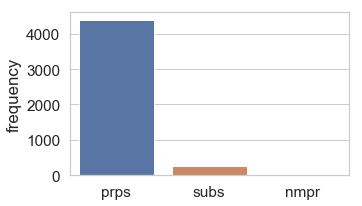

Parts of Speech for DPrP


,DPrP
prde,790.0


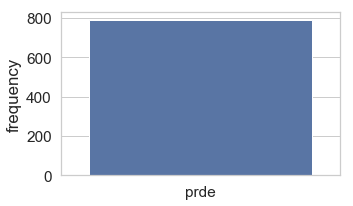

Parts of Speech for InjP


,InjP
intj,1883.0


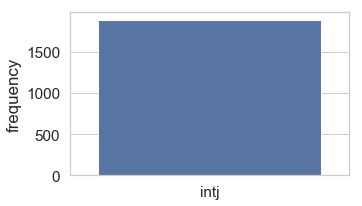

Parts of Speech for NegP


,NegP
nega,6742.0


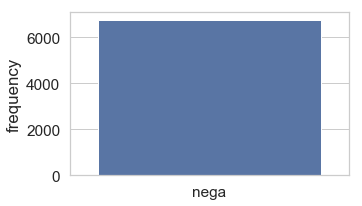

Parts of Speech for InrP


,InrP
inrg,1291.0


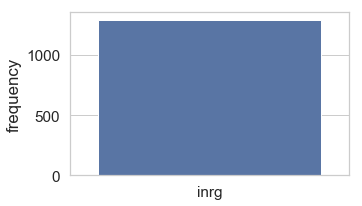

Parts of Speech for IPrP


,IPrP
prin,798.0


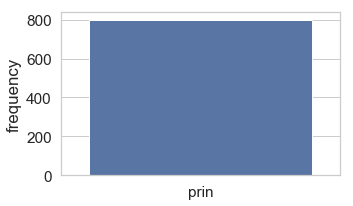

Parts of Speech for VP


,VP
verb,69024.0


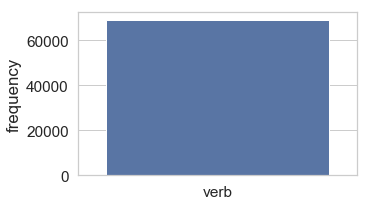

Parts of Speech for CP


,CP
conj,51341.0
prep,1140.0


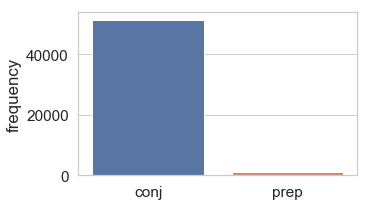

Parts of Speech for AdjP


,AdjP
adjv,1866.0
subs,4.0
advb,1.0


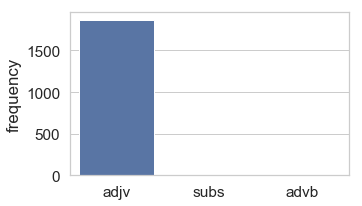

Parts of Speech for AdvP


,AdvP
advb,5172.0
subs,368.0
nmpr,234.0
prep,2.0


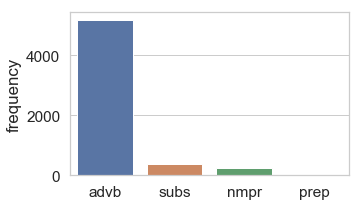

Parts of Speech for PP


,PP
prep,61498.0


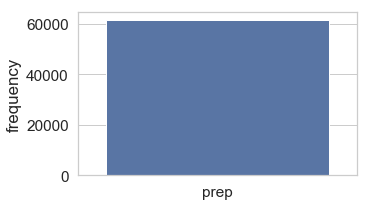

Parts of Speech for NP


,NP
subs,44729.0
nmpr,149.0
adjv,117.0
prde,49.0
prps,4.0
intj,1.0


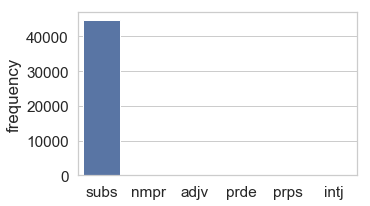

Parts of Speech for PrNP


,PrNP
nmpr,11633.0
subs,331.0
prps,1.0


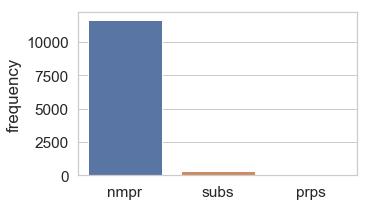

In [65]:
sns.set(style='whitegrid', font_scale=1.4)

for typ in typ2pdpcounts:
    positive = typ2pdpcounts[typ][typ2pdpcounts[typ] > 0].sort_values(ascending=False)
    
    print(f'Parts of Speech for {typ}')
    display(pd.DataFrame(positive))
    
    plt.figure(figsize=(5, 3))
    sns.barplot(x=positive.index, y=positive)
    plt.ylabel('frequency')
    plt.show()

## Evaluating Quantifiers

By far, quantifiers are the most tricky of issues involved in picking out heads. Let's evaluate how many and which quantifiers have been selected.

In all cases, a quantifier should only be selected if it is not followed by a quantified noun. These quantifiers are selected with the `NP_quant_alone` query above. A quantifier should not have been selected in any other case.

In [66]:
len([head for phrase, heads in phrase2heads.items()
            for head in heads if head in quantifiers
            if F.typ.v(phrase) in {'NP', 'PrNP'}]) <= 1731 # less or equal quantifier heads than what NP_quant_alone found

False

This is a good result. Let's check whether there are quantifiers in other phrase types.

In [67]:
A.show([(phrase, head) for phrase, heads in phrase2heads.items()
            for head in heads if head in quantifiers
            if F.typ.v(phrase) not in {'NP', 'PrNP'}], condenseType='phrase', withNodes=True)



**phrase** *1*





**phrase** *2*





**phrase** *3*





**phrase** *4*





**phrase** *5*





**phrase** *6*





**phrase** *7*





**phrase** *8*





**phrase** *9*





**phrase** *10*





**phrase** *11*





**phrase** *12*





**phrase** *13*





**phrase** *14*





**phrase** *15*





**phrase** *16*





**phrase** *17*





**phrase** *18*





**phrase** *19*





**phrase** *20*





**phrase** *21*





**phrase** *22*





**phrase** *23*





**phrase** *24*





**phrase** *25*





**phrase** *26*





**phrase** *27*





**phrase** *28*





**phrase** *29*



These quantifiers are all well-chosen. 

Next, I want to check whether there are any cases of a cardinal number and a substantive occuring together as head elements. These combinations often identify mismatched quantifiers.

In [68]:
card_mix = [(phrase,)+tuple(heads) for phrase, heads in phrase2heads.items()
                 if [w for w in heads if F.ls.v(w) == 'card']
                 and [w for w in heads if F.ls.v(w) != 'card']]

len(card_mix)

7

In [69]:
A.show(card_mix, condenseType='phrase', withNodes=True, end=100)



**phrase** *1*





**phrase** *2*





**phrase** *3*





**phrase** *4*





**phrase** *5*





**phrase** *6*





**phrase** *7*



It is good that there are only 7 such cases. All of these cases appear to be permissible combinations of quantifiers and nominals, where the quantifier stands as its own element. In the first case, it is perhaps conceivable that the quantifier should be omitted, and זכן be selected instead. However, such a situation is a semantic choice that cannot be easily automated. There are many additional concerns that this method would need to address.

Next, I want to know whether any cardinal quantifiers have unfairly been excluded from head roles by the strict requirements for standalone quantifiers. This would occur in phrases that only contain standalone quantifiers. This will require a search of its own, followed by a comparison of the search's heads with the selected heads.

In [70]:
all_cards = A.search(f'''

phrase typ=NP|PrNP

% all non-conj./art. words in phrase are cardinals
/where/
    word pdp#conj|art
/have/
    ls=card
/-/

    phrase_atom rela=NA|Para
        quantifier:quant

% require either NA subphrase relation
% or no subphrase embedding:
        /with/
        subphrase rela=NA|par
            quantifier
        /or/
        /without/
        subphrase
            quantifier
        /-/
        /-/

% exclude uses as modifier:
        /without/
        subphrase rela=adj|atr|rec|mod|dem
            quantifier
        /-/
        
% ensure word is not immediately preceded by a construct form
        /without/
        phrase_atom
            word st=c
            <: quantifier
        /-/

% ensure quantifier is not immediately preceded by a preposition
        /without/
        phrase_atom
            word pdp=prep
            <: quantifier
        /-/
        /without/
        phrase_atom
            word pdp=prep
            <: word pdp=art
            <: quantifier
        /-/
''', sets={'quant': quantifiers})

all_cards_heads = set(res[2] for res in all_cards)
select_cards_heads = set(head for phrase, heads in phrase2heads.items() for head in heads if F.ls.v(head) == 'card')

print(f'\n{len(all_cards_heads - select_cards_heads)} missing standalone quantifiers...')

  1.14s 1031 results

0 missing standalone quantifiers...


This is a good result. The search found 1031 phrase heads in cardinal-only phrases. All of these heads are contained in the `heads2` dataset. 

Note that the `NP_quant_alone` pattern found more. This is expected since `NP_quant_alone` is a more sophisticated search that checks between phrase atoms for various relations. We have already tested above to make sure those selections are valid. But just to be sure, which results did the `all_cards` pattern above not find? Below is a small sampling. They often have to do with additional modifiers on the cardinal number contained in a separate phrase_atom.

In [71]:
test = [(L.u(head, 'phrase')[0],)+tuple(phrase2heads[L.u(head, 'phrase')[0]]) for head in select_cards_heads - all_cards_heads]

A.show(test, condenseType='phrase', withNodes=True, end=5)



**phrase** *1*





**phrase** *2*





**phrase** *3*





**phrase** *4*





**phrase** *5*



## Inspecting Missing Relation Cases

At the beginning of this notebook, I made numerous exclusions of heads using the `dword` (dependent word) and `iword` (independent word) sets. This is because the BHSA omits multiple relations between words that should be there. We have excluded those words. Let's evaluate how well those phrases performed in the head selection process:

In [72]:
for word in L.d(792539, 'word'):
    print(word, T.text(word), word in dwords)

239841 חֶ֛סֶד  False
239842 מִשְׁפָּ֥ט  False
239843 וּ False
239844 צְדָקָ֖ה  False


In [73]:
show_subphrases(792539)

-------1363416----------------

חֶ֛סֶד מִשְׁפָּ֥ט  -NA-> 
nodes:  1363416 -NA-> 
slots:  [239841, 239842] -NA-> ()
------------------------------
-------1363417----------------

צְדָקָ֖ה  -par-> חֶ֛סֶד מִשְׁפָּ֥ט 
nodes:  1363417 -par-> 1363416
slots:  [239844] -par-> [239841, 239842]
------------------------------


In [74]:
NP_missing_atr_rec = [(res[0],) + tuple(phrase2heads[res[0]]) for res in missing_atr_rec 
                          if F.typ.v(res[0]) in {'NP', 'PrNP'}]

A.show(NP_missing_atr_rec)



**phrase** *1*





**phrase** *2*





**phrase** *3*





**phrase** *4*





**phrase** *5*





**phrase** *6*





**phrase** *7*





**phrase** *8*





**phrase** *9*





**phrase** *10*





**phrase** *11*





**phrase** *12*





**phrase** *13*





**phrase** *14*





**phrase** *15*





**phrase** *16*





**phrase** *17*





**phrase** *18*





**phrase** *19*





**phrase** *20*





**phrase** *21*





**phrase** *22*





**phrase** *23*





**phrase** *24*





**phrase** *25*





**phrase** *26*





**phrase** *27*





**phrase** *28*





**phrase** *29*





**phrase** *30*





**phrase** *31*





**phrase** *32*





**phrase** *33*





**phrase** *34*





**phrase** *35*





**phrase** *36*





**phrase** *37*





**phrase** *38*





**phrase** *39*





**phrase** *40*





**phrase** *41*





**phrase** *42*



## Random Evaluations

We have examined methodically the different aspects of the selected heads, including their statistical distribution in terms of parts of speech, as well as looking for mixed or missed heads within quantifiers. Now we turn to a less methodical, but nonetheless important, evaluation measure: that of random sampling and manual inspection. The code below aims to produce the most varied sets of manual sampling, accross a wide array of phrase types. Since some phrase types are statistically dominant, the code selects a random phrase type that is then used to select a random node of that type. The algorithm runs until producing 50 random samples, with no duplicates allowed. The sample set can be re-shuffled with new random results by running the first cell before displaying the results. There is also an option to pick results with more than a given number of heads, to show more complex examples.

In [75]:
# RUNNING THIS REMOVES PREVIOUSLY DISPLAYED RESULTS

min_words = 2
min_heads = 1

type2headresults = collections.defaultdict(list) # map types to result nodes
maxlength = collections.defaultdict(lambda: collections.defaultdict(int))
for phrase, heads in phrase2heads.items():
    typ = F.typ.v(phrase)
    type2headresults[typ].append((phrase,)+tuple(heads))
    phrase_len, head_len = len(L.d(phrase,'word')), len(heads)
    if phrase_len > maxlength[typ]['phrase']:
        maxlength[typ]['phrase'] = phrase_len
    if head_len > maxlength[typ]['head']:
        maxlength[typ]['head'] = head_len

samples = set() # to fill with 50
while len(samples) < 50:
        typ = random.choice(list(type2headresults.keys()))
        while maxlength[typ]['phrase'] < min_words or maxlength[typ]['head'] < min_heads: # don't pick type without size threshold
            typ = random.choice(list(type2headresults.keys()))
            
        choice = random.choice(type2headresults[typ])
        while len(L.d(choice[0], 'word')) < min_words or len(choice[1:]) < min_heads:
            choice = random.choice(type2headresults[typ])
        samples.add(choice)
        
samples = list(samples)

In [76]:
A.show(list(samples), condenseType='phrase', withNodes=True)



**phrase** *1*





**phrase** *2*





**phrase** *3*





**phrase** *4*





**phrase** *5*





**phrase** *6*





**phrase** *7*





**phrase** *8*





**phrase** *9*





**phrase** *10*





**phrase** *11*





**phrase** *12*





**phrase** *13*





**phrase** *14*





**phrase** *15*





**phrase** *16*





**phrase** *17*





**phrase** *18*





**phrase** *19*





**phrase** *20*





**phrase** *21*





**phrase** *22*





**phrase** *23*





**phrase** *24*





**phrase** *25*





**phrase** *26*





**phrase** *27*





**phrase** *28*





**phrase** *29*





**phrase** *30*





**phrase** *31*





**phrase** *32*





**phrase** *33*





**phrase** *34*





**phrase** *35*





**phrase** *36*





**phrase** *37*





**phrase** *38*





**phrase** *39*





**phrase** *40*





**phrase** *41*





**phrase** *42*





**phrase** *43*





**phrase** *44*





**phrase** *45*





**phrase** *46*





**phrase** *47*





**phrase** *48*





**phrase** *49*





**phrase** *50*



# `obj_prep`

The feature `prep_obj` in `v.1` was an edge feature from a word to its governing preposition. As is done with the nouns above, this would would be a nominal element that is disambiguated from its quantifiers. Since there is no dependency of a prepositional object, the nominal templates developed above can be used with the single change that the phrase type is a `PP` or `CP` (which also has prepositional objects!). 

Since `v.2` will encode edges from words to phrases rather than the other way around, this feature will encode an edge from the object to the preposition, hence the new feature name.

<hr>

In [77]:
pp_obj_queries = {}
    
PP_noqant = f'''

phrase_atom
    prep prs=absent
    < head:nonquant pdp#conj|art|prep|nega

% either word is adjacent to prep
    /with/
    phrase_atom
        prep
        <: head
        
% or word is adjacent to prep but interrupted by article
    /or/
    phrase_atom
        prep
        <: word pdp=art
        <: head
    
    /or/

% or word is w1, an independent, non-modifying word
% what follows is a long description for that situation

    w1:word

% exclude w1 uses as modifier
    /without/
    subphrase rela=adj|atr|mod|dem
        w1
    /-/
    /with/
    = iword
    /-/

% exclude w1 rec relations to non-prepositions
    /without/
    nonprep
    <mother- subphrase rela=rec
        w1
    /-/

% ensure w1 is not immediately preceded by a construct form
    /without/
    phrase_atom
        nonprep st=c
        <: w1
    /-/
    

% exclude cases where word occurs in a subphrase immediately before a preposition
% only 1 case of this, but may be other edge cases this misses.
    /without/
    s1:subphrase
        prep
    s2:subphrase rela=par
        w1
        <: prep
    s1 <mother- s2
    /-/
    
    w1 = head
    /-/

'''

pp_obj_queries['PP_noqant'] = {'template': PP_noqant,
                               'prepi': 1,
                               'obji': 2}

PP_quant_alone = f'''

phrase_atom
    prep prs=absent
    < quantifier:quant

% quantifier does not precede a quantified element within a subphrase
    /without/
    subphrase
        quantifier
        < w1:nonquantprep pdp=subs|adjv|advb|nmpr|prde|prps
    
        /without/
        = postprep
        /-/
        
        /without/
        subphrase
        /without/
            quant
        /-/
            prep
            < w1
        /-/
    /-/ 
    

% quantifier not immediately adjacent to quantified element within a phrase_atom
    /without/
    phrase_atom
        quantifier
        <: w1:nonquantprep pdp=subs|nmpr|prde|prps
    /-/
    /without/
    phrase_atom
        quantifier
        <: word pdp=art
        <: w1:nonquantprep pdp=subs|nmpr|prde|prps
    /-/
    /without/
    phrase_atom
        w1:nonquantprep pdp=subs|nmpr|prde|prps
        <: quantifier
    /-/
    /without/
    phrase_atom
        w1:nonquantprep pdp=subs|nmpr|prde|prps
        <: word pdp=art
        <: quantifier
    /-/
        
% quantifier is not construct with quantified element
    /without/
    quantifier
    <mother- subphrase rela=rec
        nonquantprep pdp=subs|adjv|advb|nmpr|prde|prps
    /-/
    /without/
    phrase_atom
        quantifier st=c
        <: nonquantprep pdp=subs|adjv|advb|nmpr|prde|prps
    /-/
    
% quantifier is not in another relation with a quantified element
    /without/
    s1:subphrase
        quantifier
    s2:subphrase rela=adj|atr|dem
        w1:nonquantprep pdp=subs|adjv|advb|nmpr|prde|prps 
        /without/
        = postprep
        /-/
        /without/
        subphrase
        /without/
            quant
        /-/
            < prep
            w1
        /-/
        
    s1 <mother- s2
    /-/

% ensure quantifer is not in a quantifying chain
    /without/
    phrase_atom
    /with/
        s1:subphrase
            nonprep pdp=subs|adjv|nmpr|prde|prps lex#{quantlexs} ls#card
        s2:subphrase rela=adj|atr
            word ls=card
        s1 <mother- s2
    /or/
        s1:subphrase
            word ls=card
        s2:subphrase rela=adj|atr
            w1:nonprep pdp=subs|adjv|nmpr|prde|prps lex#{quantlexs} ls#card
            /without/
            = postprep
            /-/
            /without/
            subphrase
            /without/
                quant
            /-/
                < prep
                w1
            /-/
        s1 <mother- s2
    /-/
        quantifier ls=card prs=absent
    /-/

% exclude uses as modifier:
    /without/
    subphrase rela=adj|atr|rec|mod|dem
        quantifier
        w1:word
        /without/
        = postprep
        /-/
        quantifier = w1
    /-/
    /with/
    = iword
    /-/
'''

pp_obj_queries['PP_quant_alone'] = {'template': PP_quant_alone,
                                    'prepi': 1,
                                    'obji': 2}

PP_quantified = f'''


phrase_atom
    prep prs=absent
   
% ensure that word is quantified with a head-word quantifier
% NB: what follows is a long chain of specs on quantifier

    < quantifier:quant

    /with/
    phrase_atom
        prep
        <: quantifier
    /or/
    
% quantifier not used in rec relations to non-prepositions
    /without/
    nonprep
    <mother- subphrase rela=rec
        quantifier
        w1:word
        /without/
        phrase_atom
            prep
            <: w1
        /-/
        /without/
        phrase_atom
            prep
            <: word pdp=art
            <: w1
        /-/
        w1 = quantifier
    /-/

% quantifier not used in adj relations to non-quantifiers
    /without/
    subphrase
    /with/
        nonquant pdp#conj|art
    /-/
    <mother- subphrase rela=adj
        quantifier
        w1:word
        /without/
        prep
        <: w1
        /-/
        w1 = quantifier
    /-/
    /-/

% ------------------------------
% NB: what follows is a long chain of specs on head

% require adjacency to quantifier
    <1: subphrase
        head:nonquant pdp=subs|adjv|advb|nmpr|prde|prps
        
        /with/
        phrase_atom
            prep
            <: quant
            <: head

        /or/
        phrase_atom
            prep
            <: quant
            <: word pdp=art
            <: head
        
        /or/
    
% quantified word is not a dependent modifier
% exclude construct state to non quants/preps
        /without/
        nonquantprep st=c
        <: head
        /-/
        /without/
        nonquantprep st=c
        <: word pdp=art
        <: head
        /-/

% iword requirements
        /with/
        = iword
        /or/
        quant
        <: ..
        /or/
        quant
        <: word pdp=art
        <: ..
        /or/
        ..
        <: quant
        /-/

% exclude non-quant/prep rec relas
        /without/
        nonquantprep
        <mother- subphrase rela=rec
            head
        /-/
    
% exclude non-quant para rec relas
        /without/
        nonquantprep
        <mother- subphrase rela=rec
        <mother- subphrase rela=par
            head
        /-/
        
% exclude non-quant adjunct relas
        /without/
        subphrase
        /without/
            := quant
        /-/
        <mother- subphrase rela=adj
            head
        /-/
    
% exclude non-quant para adjunct relas
        /without/
        subphrase
        /without/
            := quant
        /-/
        <mother- subphrase rela=adj
        <mother- subphrase rela=par
            head
        /-/

% exclude demonstrative relas when demonstrative points to subphrase with words other than quantifiers
        /without/
        subphrase
        /with/
            nonquant pdp#art|conj
        /-/
        <mother- subphrase rela=dem
            head 
        /-/

% exclude all other kinds of relations
        /without/
        subphrase rela=atr|mod
            head
        /-/
        /-/
'''

pp_obj_queries['PP_quantified'] = {'template': PP_quantified,
                                   'prepi': 1,
                                   'obji': 4}
    
special_quantified = '''

% necessary due to technical limitation in search patterns
phrase_atom
    prep
    <: quant
    <: nonquant pdp=subs|adjv|advb|nmpr|prde|prps
'''
pp_obj_queries['special_quantified'] = {'template': special_quantified,
                                        'prepi': 1,
                                        'obji': 3}
    
PP_to_PP = '''

phrase_atom
    prep
    <: prep
'''

pp_obj_queries['PP_to_PP'] = {'template': PP_to_PP,
                              'prepi': 1,
                              'obji': 2}
    
PP_to_conj = '''

phrase_atom
    prep
    <: word pdp=conj
    
    /with/
    phrase_atom typ=CP
        ..
    /or/
    lex=C|>CR
    /-/
'''

pp_obj_queries['PP_to_conj'] = {'template': PP_to_conj,
                                'prepi': 1,
                                'obji': 2}

PP_negation = '''

pa:phrase_atom
    pp:prep
    neg:word pdp=nega

pa =: pp
pa := neg
pp # neg
'''
pp_obj_queries['PP_negation'] = {'template': PP_negation,
                                'prepi': 1,
                                'obji': 2}



obj2prep = collections.defaultdict()
prep2obj = collections.defaultdict(set)

for name, query in pp_obj_queries.items():
    template = query['template']
    prepi = query['prepi']
    obji = query['obji']
    
    print(f'running query on {name}...')
    results = A.search(template, sets=sets)

    print('\tprocessing prepositions...')
    for res in results:
        obj = res[obji]
        # back up one slot until a preposition is found
        prep = None
        cur_slot = obj
        while not prep:
            cur_slot -= 1
            if cur_slot in preps:
                prep = cur_slot
                
        obj2prep[obj] = prep
        prep2obj[prep].add(obj)
        
print('\n', '<>'*20, '\n')
print(f'queries complete with {len(obj2prep)} object of preposition mappings...')

running query on PP_noqant...
  1.87s 66077 results
	processing prepositions...
running query on PP_quant_alone...
  0.12s 829 results
	processing prepositions...
running query on PP_quantified...
  1.50s 5142 results
	processing prepositions...
running query on special_quantified...
  0.62s 1959 results
	processing prepositions...
running query on PP_to_PP...
  0.22s 2917 results
	processing prepositions...
running query on PP_to_conj...
  0.54s 1055 results
	processing prepositions...
running query on PP_negation...
  0.62s 1 result
	processing prepositions...

 <><><><><><><><><><><><><><><><><><><><> 

queries complete with 64217 object of preposition mappings...


<hr>

## Check for Missing Prepositional Objects


In [78]:
# for testing:
for sp in L.d(0, 'subphrase'):
    print(sp, F.rela.v(sp), E.mother.f(sp), T.text(sp))
    print(L.d(sp, 'word'))
    print()

In [79]:
simple_check_results = A.search('''

phrase_atom
    prep prs=absent
    <: word pdp#conj
    
''', sets={'prep': preps})

simple_check_prep = [res for res in simple_check_results if res[1] not in prep2obj]

print(f'{len(simple_check_prep)} prepositions missing...')

A.show(simple_check_prep, withNodes=True, condenseType='phrase_atom', end=100)

  1.07s 62424 results
0 prepositions missing...


### Random Inspection


In [80]:
random_results = [(L.u(obj, 'phrase_atom')[0], prep, obj) for obj, prep in obj2prep.items()
                     if len(prep2obj[prep]) > 1
                 ]
random.shuffle(random_results)
random_results = [res for res in random_results 
                      #if len(L.d(res[0], 'word')) > 5
                 ]

random_results.insert(0, (898847,)+tuple(prep2obj[898847])) # <- suspect
len(random_results)

1262

In [81]:
for i in range(0, 50):
    
    res = random_results[i]
    show = {}
    
    for word in L.d(res[0], 'word'):
        if word in obj2prep:
            
            show[word] = 'pink'
            show[obj2prep[word]] = 'lightblue'

    result = (res[0],) + tuple(show.keys())
                    
    A.prettyTuple(result, condenseType='phrase_atom', withNodes=True, seqNumber=i, highlights=show)



**Result** *0*





**Result** *1*





**Result** *2*





**Result** *3*





**Result** *4*





**Result** *5*





**Result** *6*





**Result** *7*





**Result** *8*





**Result** *9*





**Result** *10*





**Result** *11*





**Result** *12*





**Result** *13*





**Result** *14*





**Result** *15*





**Result** *16*





**Result** *17*





**Result** *18*





**Result** *19*





**Result** *20*





**Result** *21*





**Result** *22*





**Result** *23*





**Result** *24*





**Result** *25*





**Result** *26*





**Result** *27*





**Result** *28*





**Result** *29*





**Result** *30*





**Result** *31*





**Result** *32*





**Result** *33*





**Result** *34*





**Result** *35*





**Result** *36*





**Result** *37*





**Result** *38*





**Result** *39*





**Result** *40*





**Result** *41*





**Result** *42*





**Result** *43*





**Result** *44*





**Result** *45*





**Result** *46*





**Result** *47*





**Result** *48*





**Result** *49*



# `nheads`

In many cases one does not want to go through prepositions to reach the nominal head elements (i.e. independent substantive, adjective, etc.) in a phrase. For this we can export an additional feature, called `nheads` ("nominal heads"), which simply ignores any prepositions and selects the nominal elements from the phrase and phrase atoms. This feature is built up using the `phrase2heads` and `prep2obj` features already calculated above. 

### Note on AdjP
This feature does not select nominals that are embedded within an adjective phrase (`AdjP`), but those can be selected with the following pattern:

In [82]:
adj_nhead = '''

phrase_atom typ=AdjP
    w1:word 
    /with/
    word pdp=adjv
    <mother- subphrase rela=rec
        w1
    /-/

'''

A.show(A.search(adj_nhead), condenseType='phrase_atom', end=5)

  1.08s 201 results




**phrase_atom** *1*





**phrase_atom** *2*





**phrase_atom** *3*





**phrase_atom** *4*





**phrase_atom** *5*



In [83]:
def find_prep_nominal(preposition, nominals=[]):
    '''
    This function recursively
    moves through prepositional
    chains to obtain the ultimate 
    governed nominal element.
    '''
    objects = prep2obj.get(preposition, None)
    if objects:
        for obj in objects:
            if obj not in sets['prep']:
                nominals.append(obj)
            else:
                find_prep_nominal(obj, nominals=nominals)

In [84]:
nheads = collections.defaultdict(set)

for phrase, heads in phrase2heads.items():
    for head in heads:
        if head not in sets['prep']:
            nheads[phrase].add(head)
        else:
            nominals = []
            find_prep_nominal(head, nominals=nominals)
            if nominals:
                nheads[phrase] |= set(nominals)
            
print(f'{len(nheads)} nheads assigned...')
print(f'{len(phrase2heads)-len(nheads)} phrases not assigned an nhead...')

240412 nheads assigned...
12795 phrases not assigned an nhead...


In [85]:
examples = [(phrase,)+tuple(heads) for phrase, heads in nheads.items()
               #if F.typ.v(phrase) == 'PP'
                if len(heads) > 1
           ]

random.shuffle(examples)

In [86]:
for res in examples[:50]:
    A.prettyTuple(res, condenseType='phrase', withNodes=True, seqNumber=res[0])



**Result** *698662*





**Result** *655979*





**Result** *864878*





**Result** *721872*





**Result** *883894*





**Result** *701876*





**Result** *875726*





**Result** *693094*





**Result** *812114*





**Result** *901662*





**Result** *707604*





**Result** *672141*





**Result** *840537*





**Result** *698440*





**Result** *701931*





**Result** *898142*





**Result** *820857*





**Result** *831558*





**Result** *724693*





**Result** *736026*





**Result** *669497*





**Result** *678985*





**Result** *825493*





**Result** *672371*





**Result** *752677*





**Result** *846461*





**Result** *667957*





**Result** *888109*





**Result** *744242*





**Result** *839989*





**Result** *668154*





**Result** *874390*





**Result** *752311*





**Result** *778136*





**Result** *661532*





**Result** *749610*





**Result** *750362*





**Result** *755237*





**Result** *831683*





**Result** *789309*





**Result** *658414*





**Result** *889163*





**Result** *884376*





**Result** *875893*





**Result** *770582*





**Result** *664884*





**Result** *848629*





**Result** *819569*





**Result** *799529*





**Result** *723111*



<hr>

# Issues Tracking

This section is dedicated to tracking and dealing with issues that are caused by deficiencies in the BHSA data and which cannot easily be solved even with a patch.

In [87]:
known_issues = {} # curr empty; will add more if they emerge and I cannot immediately address

In [88]:
# for phrase, note in known_issues.items():
#     A.prettyTuple((phrase,)+tuple(nheads[phrase]), seqNumber=note)
#     show_subphrases(phrase)

## Cautions

The following cases contain cautions as they require further investigation or may be debateable.

In [89]:
cautions = []

ezra_4_13 = '''

book book@en=Ezra
    chapter chapter=4
        verse verse=13
            phrase
                =: word lex=MDH/
'''
ezra413_note = '''
Is the word בלו in this phrase a head or a modifying element of מנדה? It is connected with a maqqeph. 
Its interpretation affects what one does with the next nominal: הלך. The head has been selected in
this way because the pattern in this phrase conforms with other cases where a modifying element connected
with maqqeph is followed by coordination.
'''
cautions.append({'template':ezra_4_13, 'phrasei':3, 'note':ezra413_note})

The cautions are all displayed below with their notes.

In [90]:
for i, caution in enumerate(cautions):
    caution_res = A.search(caution['template'], silent=True)
    phrase = caution_res[0][caution['phrasei']]
    A.prettyTuple((phrase,)+tuple(nheads[phrase]), seqNumber=caution['note'])



**Result** *
Is the word בלו in this phrase a head or a modifying element of מנדה? It is connected with a maqqeph. 
Its interpretation affects what one does with the next nominal: הלך. The head has been selected in
this way because the pattern in this phrase conforms with other cases where a modifying element connected
with maqqeph is followed by coordination.
*



<hr>
<br>
<br>
<br>

# Testing & Scratch Code

## TO DO

* TO FIX: 713495, 902589, 865297 parallel relation to dwords

In [87]:
# probs = set()

# for phrase in (713495, 902589, 865297, 
#                865119, 865280,  865306, 
#                881928, 686550, 719764, 
#                883150, ):
#     problem = sorted(nheads[phrase])[-1]
#     A.prettyTuple((phrase, problem), seqNumber=phrase)
#     probs.add(phrase)
    
# probs

In [88]:
# # FOR BIG TESTS

# test1 = missing_atr_rec = A.search('''

# phrase
#     phrase_atom
#         subs:word pdp=subs|nmpr    
# % stipulate that this word has some relation to the following word
# % there are various checks to weed out spurious results:
#         /with/
#         st=c
#         /or/
#         ..
#         <: word pdp=adjv
#         /or/
#         trailer=&
#         /or/
#         s1:subphrase
#             =: subs
#             <: w1:word pdp=adjv|subs
#         w1 := s1
#         /-/
        
#         <: ad:word pdp=adjv|subs
# % stipulate that this^ word has no relation to the first
#         /without/
#         s1:subphrase
#             w1:word
#         s2:subphrase rela=atr|adj|par|mod
#             w2:word
#         s1 <mother- s2
#         w1 <: w2
#         ad = w2
#         /-/
#         /without/
#         w1:word
#         s1:subphrase rela=rec
#             w2:word
#         w1 <mother- s1
#         w1 <: w2
#         ad = w2
#         /-/

# ''', silent=True) + A.search('''

# phrase
#     phrase_atom
#         word pdp=subs|nmpr
#         <: word pdp=art
#         <: ad:word pdp=adjv|subs
# % stipulate that this^ word has no relation to the first
#         /without/
#         s1:subphrase
#             w1:word pdp=subs|nmpr
#         s2:subphrase rela=atr|adj|par|mod
#             w2:word pdp=art
#             <: w3:word
            
#         s1 <mother- s2
#         w1 <: w2
#         ad = w3
#         /-/
        
#         /without/
#         w1:word pdp=subs|nmpr
#         s1:subphrase rela=rec
#             w2:word pdp=art
#             w3:word
            
#         w1 <mother- s1
#         w1 <: w2
#         ad = w3
#         /-/
# ''', silent=True)

# test2 = missing_atr_rec = A.search('''

# phrase
#     phrase_atom
#         subs:word pdp=subs|nmpr    
# % stipulate that this word has some relation to the following word
# % there are various checks to weed out spurious results:
#         /with/
#         st=c
#         /or/
#         ..
#         <: word pdp=adjv
#         /or/
#         trailer=&
#         /or/
#         s1:subphrase
#             =: subs
#             <: w1:word pdp=adjv|subs
#         w1 := s1
#         /-/
        
#         <: ad:word pdp=adjv|subs
# % stipulate that this^ word has no relation to the first
#         /without/
#         s1:subphrase
#             w1:word
#         s2:subphrase rela=atr|adj|par|mod
#             w2:word
#         s1 <mother- s2
#         w1 <: w2
#         ad = w2
#         /-/
#         /without/
#         w1:word
#         s1:subphrase rela=rec
#             w2:word
#         w1 <mother- s1
#         w1 <: w2
#         ad = w2
#         /-/

# ''', silent=True) + A.search('''

# phrase
#     phrase_atom
#         word pdp=subs|nmpr
#         <: word pdp=art
#         <: ad:word pdp=adjv|subs
# % stipulate that this^ word has no relation to the first
#         /without/
#         s1:subphrase
#             w1:word pdp=subs|nmpr
#         s2:subphrase rela=atr|adj|par|mod
#             w2:word pdp=art
#             <: w3:word
            
#         s1 <mother- s2
#         w1 <: w2
#         ad = w3
#         /-/
        
#         /without/
#         w1:word pdp=subs|nmpr
#         s1:subphrase rela=rec
#             w2:word pdp=art
#             w3:word
            
#         w1 <mother- s1
#         w1 <: w2
#         ad = w3
#         /-/
# ''', silent=True)

# #test2 = set(A.search(test2, sets=sets)) 
# #test1 = set(A.search(test1, sets=sets))
    
# print('test1 - test2\t', len(test1-test2))
# print('test2 - test1\t', len(test2-test1))

<hr>

In [89]:
def find_differexnce(tempA, tempB):
    # prints line by line difference between two templates 
    
    t1lines = tempA.split('\n')
    t2lines = tempB.split('\n')

    for i in range(0, len(t1lines)):
        t1 = t1lines[i]
        t2 = t2lines[i]

        if t1 != t2:
            raise Exception(f'@{i}\nt1:{t1}\nt2:{t2}')